Connected to griffin (Python 3.12.1)

In [1]:
#!/usr/bin/env python
# coding=utf-8
# Copyright 2018 Google AI, Google Brain and Carnegie Mellon University Authors and the HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" Conditional text generation with the auto-regressive models of the library (GPT/GPT-2/CTRL/Transformer-XL/XLNet)
"""
import argparse
import logging


# add parent directory to path
import sys
sys.path.append('..')

import numpy as np
from cat.llama_og import get_llama_cats
# from griffin.gemma import get_gemma_griffin
# from griffin.mistral import get_mistral_griffin
# from griffin.opt import get_opt_griffin

import torch
import torch.nn.functional as F
import json
import tqdm
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from rouge import Rouge



logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)


def get_distribution(logits, temperature, epsilon=1e-8):
    logits = logits  # Move logits to the device
    logits /= (temperature + epsilon)
    probability = F.softmax(logits, dim=-1)
    return probability

/home/vashistt/ENTER/envs/griffin/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def sample(logits, temperature):
    output = get_distribution(logits, temperature)
    output = torch.multinomial(output, num_samples=1)
    return output.squeeze(1)



def set_seed(args):
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

models_sizes_dict = {
    'opt': ['125m', '350m', '1.3b', '2.7b', '6.7b', '13b', '30b', '66b'],
    'llama2': ['7b', '13b', '70b'],
    'relu_llama2': ['7B', '13B', '70B'],
    'gemma': ['2b', '7b'],
    'mistral': ['7B'],
}

hugging_name_dict = {
    'opt': lambda x: f'facebook/opt-{x}',
    'llama2': lambda x: f'meta-llama/Llama-2-{x}-hf', 
    'relu_llama2': lambda x: f"SparseLLM/ReluLLaMA-{x}",
    'gemma': lambda x: f'google/gemma-{x}',
    'mistral': lambda x: f'mistralai/Mistral-{x}-v0.1',
}


modify_dict = {
    # 'opt': get_opt_griffin,
    'llama2': get_llama_cats,
    'relu_llama2': get_llama_cats,
    # 'gemma': get_gemma_griffin,
    # 'mistral': get_mistral_griffin,
}


def set_seed(args):
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)

density = 0.5
selection_method = 'topk'
max_length=-1
k=0
max_tokens=10
seed=42
temp=0.3
greedy=False
device='cuda:1'

model_size_name = models_sizes_dict['llama2'][0]

config = AutoConfig.from_pretrained(hugging_name_dict['llama2'](model_size_name))
tokenizer = AutoTokenizer.from_pretrained(hugging_name_dict['llama2'](model_size_name), use_fast=True)
model = AutoModelForCausalLM.from_pretrained(hugging_name_dict['llama2'](model_size_name))

print("PARAMS: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
shots = 1
dataset = 'xsum'
sample_num=10

schedule_k = [density for _ in range(config.num_hidden_layers)]

if density < 1: # never enters gen so try .999 or something
    model.config.mode = 'gen'
    model.config.selection_method = selection_method
    model = modify_dict['llama2'](model, schedule_k, [1]*32, [])

model.half()
model.eval().to(device)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


PARAMS:  6738415616


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head):

In [3]:
if dataset == 'cnn':
    # input_paths = [f'../data/cnn_data/cnn_dailymail_{shots}shot.jsonl']
    input_paths = [f'/home/vashistt/Desktop/GRIFFIN-vt/data/cnn_data/cnn_dailymail_{shots}shot.jsonl']
elif dataset == 'xsum':
    # input_paths = [f'../data/xsum_data/xsum_{shots}shot.jsonl']
    input_paths = [f'/home/vashistt/Desktop/GRIFFIN-vt/data/xsum_data/xsum_1shot_100.jsonl']
else:
    raise NotImplementedError

if max_length == -1:
    max_length = config.max_position_embeddings
    # max_length = 

# Logging or return
if max_length == -1:
    max_length = config.max_position_embeddings

requests = []
for input_path in input_paths:
        with open(input_path, 'r') as f:
            for line in f:
                if line.strip() != '':
                    requests.append(json.loads(line))

requests = requests[:sample_num]

In [4]:
skipped=0
n_v_all_layer = []
tokenized_requests = []
# requests = ['What is the meaning of life?', '2+2 is 4 and how are you today', 'what is the capital of France?']

with torch.no_grad():
    for i, request in enumerate(tqdm.tqdm(requests)):        
        stop = ['###']
        temperature = temp
        label = request['summary_gt']
        prompt = request['article']
        # prompt = requests[i]
        max_tokens = max_tokens
        result = {}
        
        input_ids = tokenizer(prompt, add_special_tokens=False, return_tensors='pt')

        if len(input_ids[0]) > max_length - max_tokens:
            skipped += 1
            print('skipped', skipped)
        else:
            tokenized_requests.append(input_ids.input_ids)

100%|██████████| 10/10 [00:00<00:00, 302.15it/s]


In [5]:
# wamup 
for i in range(1):
    y = model(tokenized_requests[i].to(device))
    for number, layer in enumerate(model.model.layers):
        layer.mlp.reset_v_list()

v_list_layers_samples = torch.zeros(len(requests), 32, 1, 11008)
with torch.no_grad():
    for i in range(len(tokenized_requests)):
        y = model(tokenized_requests[i].to(device))
        v_list_layers = []
        for number, layer in enumerate(model.model.layers):
            v_list_tensor = torch.stack(layer.mlp.v_list, dim=1)
            v_list_layers.append(v_list_tensor)
            layer.mlp.reset_v_list()
        v_list_layers_tensor = torch.cat(v_list_layers, dim=0)
        v_list_layers_samples[i] = v_list_layers_tensor

len(v_list) 1
len(v_list) 2
len(v_list) 3
len(v_list) 4
len(v_list) 5
len(v_list) 6
len(v_list) 7
len(v_list) 8
len(v_list) 9
len(v_list) 10
len(v_list) 11
len(v_list) 12
len(v_list) 13
len(v_list) 14
len(v_list) 15
len(v_list) 16
len(v_list) 17
len(v_list) 18
len(v_list) 19
len(v_list) 20
len(v_list) 21
len(v_list) 22
len(v_list) 23
len(v_list) 24
len(v_list) 25
len(v_list) 26
len(v_list) 27
len(v_list) 28
len(v_list) 29
len(v_list) 30
len(v_list) 31
len(v_list) 32
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list) 1
len(v_list)

In [6]:
## Plotting
# n_samples = len(requests)
# n_layers = 32
# d = 11008
# v_list_layers_flat = v_list_layers_samples.view(-1, n_layers, d)  # Shape: (n_samples * 1, n_layer
# s, d)


def get_cdf_thresholds(v_list_layers_samples, k=0.5):
    """
    expects v_list_layers_samples of shape (n_samples, n_layers, 1, d)
    returns dict with per layer threshold value for some percentile k
    """
    n_samples = v_list_layers_samples.shape[0]
    n_layers = v_list_layers_samples.shape[1]
    d = v_list_layers_samples.shape[3]
    
    layer_threshold_k = {}

    # Flatten =
    v_list_layers_flat = v_list_layers_samples.view(-1, n_layers, d)  
    # Shape: (n_samples * 1, n_layers, d)

    # Calculate thresholds for each layer
    for layer_idx in range(n_layers):
        layer_name = f'layer_{layer_idx}'

        # Get v across samples
        all_v = v_list_layers_flat[:, layer_idx, :].flatten().numpy()
        abs_v = np.abs(all_v)

        # CDF
        sorted_abs_v = np.sort(abs_v)
        cdf = np.arange(1, len(sorted_abs_v) + 1) / len(sorted_abs_v)

        # min t such that CDF is >= k
        cdf_threshold_index = np.searchsorted(cdf, k)
        cdf_threshold_value = sorted_abs_v[cdf_threshold_index]
        layer_threshold_k[layer_name] = cdf_threshold_value
    
    print(f'_____for k={k}_______')
    print(layer_threshold_k)
    return layer_threshold_k

def save_thresholds_txt(layer_threshold_k,k_value, save_filename=None, dataset = 'xsum'):
    if save_filename is None:
        save_filename = f"thresholds_k{k_value}"
    
    with open(f"{save_filename}.txt", "w") as f:
        for key, value in layer_threshold_k.items():
            f.write(f"{key}: {value}\n")
    
    print(f"Thresholds saved to {save_filename}.txt")


## Plotting
# n_samples = len(requests)
# n_layers = 32
# d = 11008
# v_list_layers_flat = v_list_layers_samples.view(-1, n_layers, d)  # Shape: (n_samples * 1, n_layer
# s, d)


def get_cdf_thresholds(v_list_layers_samples, k=0.5):
    """
    expects v_list_layers_samples of shape (n_samples, n_layers, 1, d)
    returns dict with per layer threshold value for some percentile k
    """
    n_samples = v_list_layers_samples.shape[0]
    n_layers = v_list_layers_samples.shape[1]
    d = v_list_layers_samples.shape[3]
    
    layer_threshold_k = {}

    # Flatten
    v_list_layers_flat = v_list_layers_samples.view(-1, n_layers, d)  
    # Shape: (n_samples * 1, n_layers, d)

    # Thresholds for each layer
    for layer_idx in range(n_layers):
        layer_name = f'layer_{layer_idx}'

        # Get v across samples
        all_v = v_list_layers_flat[:, layer_idx, :].flatten().numpy()
        abs_v = np.abs(all_v)

        # CDF
        sorted_abs_v = np.sort(abs_v)
        cdf = np.arange(1, len(sorted_abs_v) + 1) / len(sorted_abs_v)

        # min t such that CDF is >= k
        cdf_threshold_index = np.searchsorted(cdf, k)
        cdf_threshold_value = sorted_abs_v[cdf_threshold_index]
        layer_threshold_k[layer_name] = cdf_threshold_value
    
    print(f'_____for k={k}_______')
    print(layer_threshold_k)
    return layer_threshold_k

def save_thresholds_txt(layer_threshold_k,k_value, save_filename=None, dataset = 'xsum'):
    if save_filename is None:
        save_filename = f"thresholds_k{k_value}"
    
    with open(f"{save_filename}.txt", "w") as f:
        for key, value in layer_threshold_k.items():
            f.write(f"{key}: {value}\n")
    
    print(f"Thresholds saved to {save_filename}.txt")

In [7]:
def plot_histograms_and_cdf(v_list_layers_samples, layer_threshold_k, y_threshold=0.001, save_plots=None, normalize=True):
    n_samples = v_list_layers_samples.shape[0]
    n_layers = v_list_layers_samples.shape[1]
    d = v_list_layers_samples.shape[3]
    v_list_layers_flat = v_list_layers_samples.view(-1, n_layers, d)  

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  

    for i, layer_idx in enumerate([0, 15, 31]):
        layer_name = f'layer_{layer_idx}'
        cdf_threshold_value = layer_threshold_k[layer_name]

        # Get v across samples
        all_v = v_list_layers_flat[:, layer_idx, :].flatten().numpy()
        abs_v = np.abs(all_v)

        hist, bins = np.histogram(abs_v, bins=300, density=True)

        # Normalize the histogram
        bin_width = bins[1] - bins[0]
        normalized_hist = hist * bin_width

        axs[i].bar(bins[:-1], normalized_hist, width=bin_width, alpha=0.75, label='Post-Activation', color='lightblue')
        axs[i].axvline(x=cdf_threshold_value, color='orange', linestyle='--', label=f'Threshold: {cdf_threshold_value:.4f}')
        
        axs[i].set_xlabel('Absolute Post-Activation')
        axs[i].set_ylabel('Frequency (Normalized)')
        axs[i].set_title(f' {layer_name} and k={k}')
        axs[i].legend(loc='upper right')
        axs[i].grid(True)

        # x-limit based on the y-values
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        y_vals = normalized_hist
        x_max = bin_centers[y_vals > y_threshold][-1] if np.any(y_vals > y_threshold) else max(bin_centers)
        axs[i].set_xlim(0, x_max)

    if save_plots is not None:
        plt.savefig(f"{save_plots}.png")
    else:
        plt.show()

In [8]:
def plot_histograms_and_cdf_filled(v_list_layers_samples, layer_threshold_k, y_threshold=0.001, save_plots=None):
    n_samples = v_list_layers_samples.shape[0]
    n_layers = v_list_layers_samples.shape[1]
    d = v_list_layers_samples.shape[3]
    v_list_layers_flat = v_list_layers_samples.view(-1, n_layers, d)  

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  

    for i, layer_idx in enumerate([0, 15, 31]):
        layer_name = f'layer_{layer_idx}'
        cdf_threshold_value = layer_threshold_k[layer_name]

        # Get v across samples
        all_v = v_list_layers_flat[:, layer_idx, :].flatten().numpy()
        abs_v = np.abs(all_v)

        within_threshold = abs_v <= cdf_threshold_value
        outside_threshold = abs_v > cdf_threshold_value

        hist, bins = np.histogram(abs_v, bins=300, density=True)
        
        bin_width = bins[1] - bins[0]
        normalized_hist = hist * bin_width

        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        within_bins = bin_centers <= cdf_threshold_value
        outside_bins = bin_centers > cdf_threshold_value

        axs[i].bar(bin_centers[within_bins], normalized_hist[within_bins], width=bin_width, alpha=0.75, label='Within Threshold', color='lightblue')
        axs[i].bar(bin_centers[outside_bins], normalized_hist[outside_bins], width=bin_width, alpha=0.75, label='Outside Threshold', color='tab:blue')

        axs[i].axvline(x=cdf_threshold_value, color='orange', linestyle='--', label=f'Threshold: {cdf_threshold_value:.4f}')
        
        axs[i].set_xlabel('Absolute Post-Activation')
        axs[i].set_ylabel('Frequency (Normalized)')
        axs[i].set_title(f'{layer_name} and k={k}')
        axs[i].legend(loc='upper right')
        axs[i].grid(True)

        y_vals = normalized_hist
        x_max = bin_centers[y_vals > y_threshold][-1] if np.any(y_vals > y_threshold) else max(bin_centers)
        axs[i].set_xlim(0, x_max)

    if save_plots is not None:
        plt.savefig(f"{save_plots}.png")
    else:
        plt.show()

In [9]:
def plot_histograms_and_cdf_filled(v_list_layers_samples, layer_threshold_k, y_threshold=0.001, save_plots=None):
    n_samples = v_list_layers_samples.shape[0]
    n_layers = v_list_layers_samples.shape[1]
    d = v_list_layers_samples.shape[3]
    v_list_layers_flat = v_list_layers_samples.view(-1, n_layers, d)  

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  

    for i, layer_idx in enumerate([0, 15, 31]):
        layer_name = f'layer_{layer_idx}'
        cdf_threshold_value = layer_threshold_k[layer_name]

        # Get v across samples
        all_v = v_list_layers_flat[:, layer_idx, :].flatten().numpy()
        abs_v = np.abs(all_v)

        within_threshold = abs_v <= cdf_threshold_value
        outside_threshold = abs_v > cdf_threshold_value

        hist, bins = np.histogram(abs_v, bins=300, density=True)
        
        bin_width = bins[1] - bins[0]
        normalized_hist = hist * bin_width

        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        within_bins = bin_centers <= cdf_threshold_value
        outside_bins = bin_centers > cdf_threshold_value

        axs[i].bar(bin_centers[within_bins], normalized_hist[within_bins], width=bin_width, alpha=0.75, label='Within Threshold', color='lightblue')
        axs[i].bar(bin_centers[outside_bins], normalized_hist[outside_bins], width=bin_width, alpha=0.75, label='Outside Threshold', color='tab:blue')

        axs[i].axvline(x=cdf_threshold_value, color='orange', linestyle='--', label=f'Threshold: {cdf_threshold_value:.4f}')
        
        axs[i].set_xlabel('Absolute Post-Activation')
        axs[i].set_ylabel('Frequency (Normalized)')
        axs[i].set_title(f'{layer_name} and k={k}')
        axs[i].legend(loc='upper right')
        axs[i].grid(True)

        y_vals = normalized_hist
        x_max = bin_centers[y_vals > y_threshold][-1] if np.any(y_vals > y_threshold) else max(bin_centers)
        axs[i].set_xlim(0, x_max)

    if save_plots is not None:
        plt.savefig(f"{save_plots}.png", dpi=300)
    else:
        plt.show()

In [10]:
## Plotting
# n_samples = len(requests)
# n_layers = 32
# d = 11008
# v_list_layers_flat = v_list_layers_samples.view(-1, n_layers, d)  # Shape: (n_samples * 1, n_layer
# s, d)


def get_cdf_thresholds(v_list_layers_samples, k=0.5):
    """
    expects v_list_layers_samples of shape (n_samples, n_layers, 1, d)
    returns dict with per layer threshold value for some percentile k
    """
    n_samples = v_list_layers_samples.shape[0]
    n_layers = v_list_layers_samples.shape[1]
    d = v_list_layers_samples.shape[3]
    
    layer_threshold_k = {}

    # Flatten =
    v_list_layers_flat = v_list_layers_samples.view(-1, n_layers, d)  
    # Shape: (n_samples * 1, n_layers, d)

    # Calculate thresholds for each layer
    for layer_idx in range(n_layers):
        layer_name = f'layer_{layer_idx}'

        # Get v across samples
        all_v = v_list_layers_flat[:, layer_idx, :].flatten().numpy()
        abs_v = np.abs(all_v)

        # CDF
        sorted_abs_v = np.sort(abs_v)
        cdf = np.arange(1, len(sorted_abs_v) + 1) / len(sorted_abs_v)

        # min t such that CDF is >= k
        cdf_threshold_index = np.searchsorted(cdf, k)
        cdf_threshold_value = sorted_abs_v[cdf_threshold_index]
        layer_threshold_k[layer_name] = cdf_threshold_value
    
    print(f'_____for k={k}_______')
    print(layer_threshold_k)
    return layer_threshold_k

def save_thresholds_txt(layer_threshold_k,k_value, save_filename=None, dataset = 'xsum'):
    if save_filename is None:
        save_filename = f"thresholds_k{k_value}"
    
    with open(f"{save_filename}.txt", "w") as f:
        for key, value in layer_threshold_k.items():
            f.write(f"{key}: {value}\n")
    
    print(f"Thresholds saved to {save_filename}.txt")


## Plotting
# n_samples = len(requests)
# n_layers = 32
# d = 11008
# v_list_layers_flat = v_list_layers_samples.view(-1, n_layers, d)  # Shape: (n_samples * 1, n_layer
# s, d)




def save_thresholds_txt(layer_threshold_k,k_value, save_filename=None, dataset = 'xsum'):
    if save_filename is None:
        save_filename = f"thresholds_k{k_value}"
    
    with open(f"{save_filename}.txt", "w") as f:
        for key, value in layer_threshold_k.items():
            f.write(f"{key}: {value}\n")
    
    print(f"Thresholds saved to {save_filename}.txt")

In [11]:
def plot_histograms_and_cdf(v_list_layers_samples, layer_threshold_k, y_threshold=0.001, save_plots=None, normalize=True):
    n_samples = v_list_layers_samples.shape[0]
    n_layers = v_list_layers_samples.shape[1]
    d = v_list_layers_samples.shape[3]
    v_list_layers_flat = v_list_layers_samples.view(-1, n_layers, d)  

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  

    for i, layer_idx in enumerate([0, 15, 31]):
        layer_name = f'layer_{layer_idx}'
        cdf_threshold_value = layer_threshold_k[layer_name]

        # Get v across samples
        all_v = v_list_layers_flat[:, layer_idx, :].flatten().numpy()
        abs_v = np.abs(all_v)

        hist, bins = np.histogram(abs_v, bins=300, density=True)

        # Normalize the histogram
        bin_width = bins[1] - bins[0]
        normalized_hist = hist * bin_width

        axs[i].bar(bins[:-1], normalized_hist, width=bin_width, alpha=0.75, label='Post-Activation', color='lightblue')
        axs[i].axvline(x=cdf_threshold_value, color='orange', linestyle='--', label=f'Threshold: {cdf_threshold_value:.4f}')
        
        axs[i].set_xlabel('Absolute Post-Activation')
        axs[i].set_ylabel('Frequency (Normalized)')
        axs[i].set_title(f' {layer_name} and k={k}')
        axs[i].legend(loc='upper right')
        axs[i].grid(True)

        # x-limit based on the y-values
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        y_vals = normalized_hist
        x_max = bin_centers[y_vals > y_threshold][-1] if np.any(y_vals > y_threshold) else max(bin_centers)
        axs[i].set_xlim(0, x_max)

    if save_plots is not None:
        plt.savefig(f"{save_plots}.png")
    else:
        plt.show()

In [12]:
def plot_histograms_and_cdf_filled(v_list_layers_samples, layer_threshold_k, y_threshold=0.001, save_plots=None):
    n_samples = v_list_layers_samples.shape[0]
    n_layers = v_list_layers_samples.shape[1]
    d = v_list_layers_samples.shape[3]
    v_list_layers_flat = v_list_layers_samples.view(-1, n_layers, d)  

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  

    for i, layer_idx in enumerate([0, 15, 31]):
        layer_name = f'layer_{layer_idx}'
        cdf_threshold_value = layer_threshold_k[layer_name]

        # Get v across samples
        all_v = v_list_layers_flat[:, layer_idx, :].flatten().numpy()
        abs_v = np.abs(all_v)

        within_threshold = abs_v <= cdf_threshold_value
        outside_threshold = abs_v > cdf_threshold_value

        hist, bins = np.histogram(abs_v, bins=300, density=True)
        
        bin_width = bins[1] - bins[0]
        normalized_hist = hist * bin_width

        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        within_bins = bin_centers <= cdf_threshold_value
        outside_bins = bin_centers > cdf_threshold_value

        axs[i].bar(bin_centers[within_bins], normalized_hist[within_bins], width=bin_width, alpha=0.75, label='Within Threshold', color='lightblue')
        axs[i].bar(bin_centers[outside_bins], normalized_hist[outside_bins], width=bin_width, alpha=0.75, label='Outside Threshold', color='tab:blue')

        axs[i].axvline(x=cdf_threshold_value, color='orange', linestyle='--', label=f'Threshold: {cdf_threshold_value:.4f}')
        
        axs[i].set_xlabel('Absolute Post-Activation')
        axs[i].set_ylabel('Frequency (Normalized)')
        axs[i].set_title(f'{layer_name} and k={k}')
        axs[i].legend(loc='upper right')
        axs[i].grid(True)

        y_vals = normalized_hist
        x_max = bin_centers[y_vals > y_threshold][-1] if np.any(y_vals > y_threshold) else max(bin_centers)
        axs[i].set_xlim(0, x_max)

    if save_plots is not None:
        plt.savefig(f"{save_plots}.png", dpi=300)
    else:
        plt.show()

_____for k=0.5_______
{'layer_0': 0.015380859, 'layer_1': 0.030838013, 'layer_2': 0.035614014, 'layer_3': 0.046936035, 'layer_4': 0.07342529, 'layer_5': 0.0993042, 'layer_6': 0.12030029, 'layer_7': 0.10925293, 'layer_8': 0.12817383, 'layer_9': 0.1361084, 'layer_10': 0.13708496, 'layer_11': 0.13977051, 'layer_12': 0.14331055, 'layer_13': 0.16052246, 'layer_14': 0.14807129, 'layer_15': 0.14794922, 'layer_16': 0.15246582, 'layer_17': 0.14770508, 'layer_18': 0.14453125, 'layer_19': 0.14611816, 'layer_20': 0.15356445, 'layer_21': 0.15856934, 'layer_22': 0.16186523, 'layer_23': 0.16174316, 'layer_24': 0.16589355, 'layer_25': 0.17163086, 'layer_26': 0.18395996, 'layer_27': 0.19177246, 'layer_28': 0.19543457, 'layer_29': 0.20935059, 'layer_30': 0.21179199, 'layer_31': 0.1899414}
Thresholds saved to xsum-20-50-threshold.txt


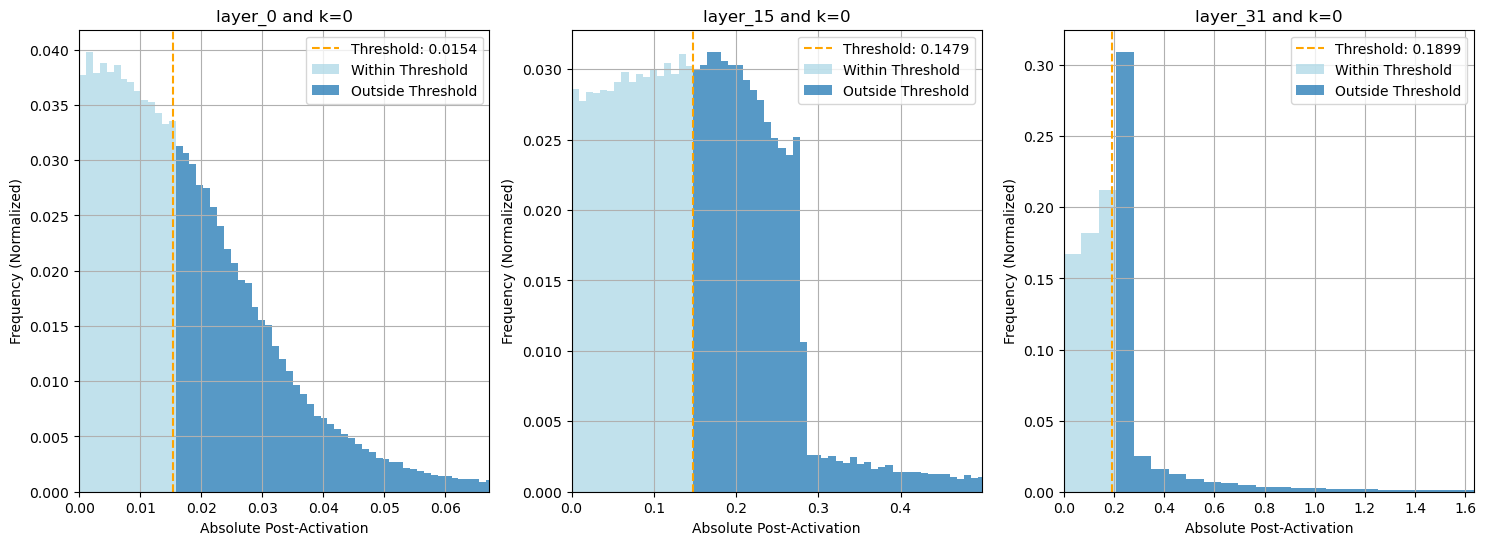

In [13]:
layer_threshold_05 = get_cdf_thresholds(v_list_layers_samples, k=0.5)
save_thresholds_txt(layer_threshold_05, 0.5, save_filename='xsum-20-50-threshold')
plot_histograms_and_cdf_filled(v_list_layers_samples, layer_threshold_05, y_threshold=0.001,save_plots='xsum-20-50-hist')

_____for k=0.5_______
{'layer_0': 0.015380859, 'layer_1': 0.030838013, 'layer_2': 0.035614014, 'layer_3': 0.046936035, 'layer_4': 0.07342529, 'layer_5': 0.0993042, 'layer_6': 0.12030029, 'layer_7': 0.10925293, 'layer_8': 0.12817383, 'layer_9': 0.1361084, 'layer_10': 0.13708496, 'layer_11': 0.13977051, 'layer_12': 0.14331055, 'layer_13': 0.16052246, 'layer_14': 0.14807129, 'layer_15': 0.14794922, 'layer_16': 0.15246582, 'layer_17': 0.14770508, 'layer_18': 0.14453125, 'layer_19': 0.14611816, 'layer_20': 0.15356445, 'layer_21': 0.15856934, 'layer_22': 0.16186523, 'layer_23': 0.16174316, 'layer_24': 0.16589355, 'layer_25': 0.17163086, 'layer_26': 0.18395996, 'layer_27': 0.19177246, 'layer_28': 0.19543457, 'layer_29': 0.20935059, 'layer_30': 0.21179199, 'layer_31': 0.1899414}
Thresholds saved to xsum-20-50-threshold.txt


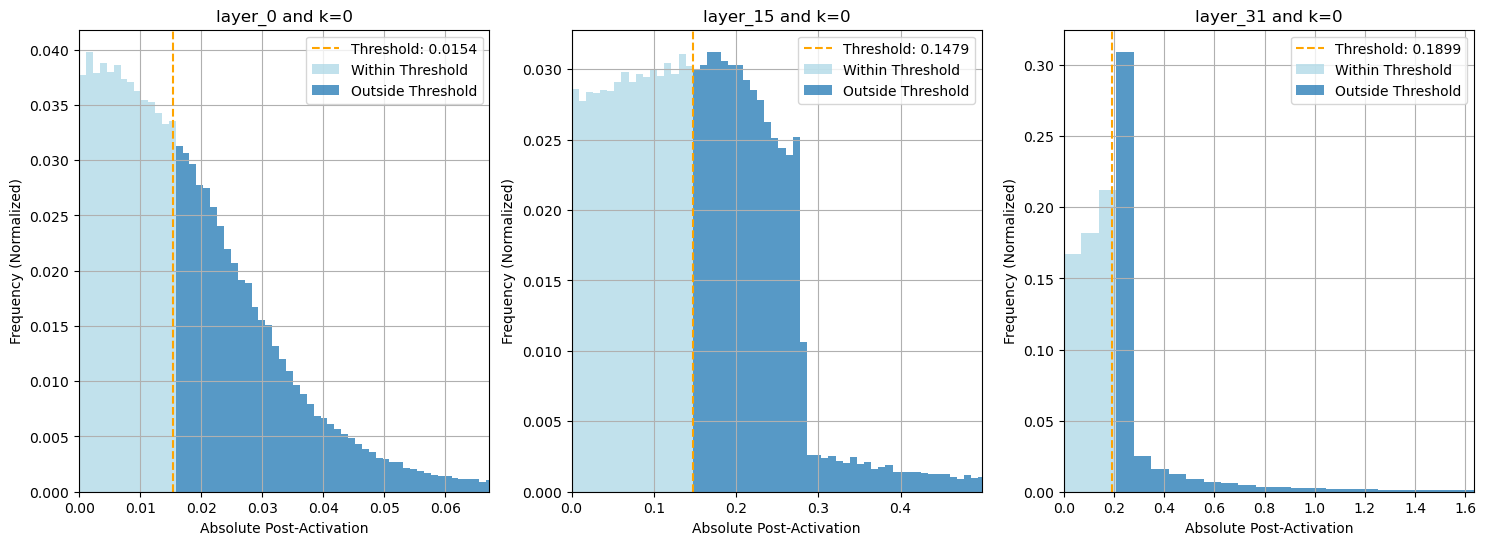

In [14]:
layer_threshold_05 = get_cdf_thresholds(v_list_layers_samples, k=0.5)
save_thresholds_txt(layer_threshold_05, 0.5, save_filename='xsum-20-50-threshold')
plot_histograms_and_cdf_filled(v_list_layers_samples, layer_threshold_05, y_threshold=0.001,save_plots='xsum-20-50-hist-300bins')

In [15]:
def plot_histograms_and_cdf_filled(v_list_layers_samples, layer_threshold_k, y_threshold=0.001, save_plots=None, bins_num = 300):
    n_samples = v_list_layers_samples.shape[0]
    n_layers = v_list_layers_samples.shape[1]
    d = v_list_layers_samples.shape[3]
    v_list_layers_flat = v_list_layers_samples.view(-1, n_layers, d)  

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  

    for i, layer_idx in enumerate([0, 15, 31]):
        layer_name = f'layer_{layer_idx}'
        cdf_threshold_value = layer_threshold_k[layer_name]

        # Get v across samples
        all_v = v_list_layers_flat[:, layer_idx, :].flatten().numpy()
        abs_v = np.abs(all_v)

        within_threshold = abs_v <= cdf_threshold_value
        outside_threshold = abs_v > cdf_threshold_value

        hist, bins = np.histogram(abs_v, bins=bins_num, density=True)
        
        bin_width = bins[1] - bins[0]
        normalized_hist = hist * bin_width

        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        within_bins = bin_centers <= cdf_threshold_value
        outside_bins = bin_centers > cdf_threshold_value

        axs[i].bar(bin_centers[within_bins], normalized_hist[within_bins], width=bin_width, alpha=0.75, label='Within Threshold', color='lightblue')
        axs[i].bar(bin_centers[outside_bins], normalized_hist[outside_bins], width=bin_width, alpha=0.75, label='Outside Threshold', color='tab:blue')

        axs[i].axvline(x=cdf_threshold_value, color='orange', linestyle='--', label=f'Threshold: {cdf_threshold_value:.4f}')
        
        axs[i].set_xlabel('Absolute Post-Activation')
        axs[i].set_ylabel('Frequency (Normalized)')
        axs[i].set_title(f'{layer_name} and k={k}')
        axs[i].legend(loc='upper right')
        axs[i].grid(True)

        y_vals = normalized_hist
        x_max = bin_centers[y_vals > y_threshold][-1] if np.any(y_vals > y_threshold) else max(bin_centers)
        axs[i].set_xlim(0, x_max)

    if save_plots is not None:
        plt.savefig(f"{save_plots}.png", dpi=300)
    else:
        plt.show()

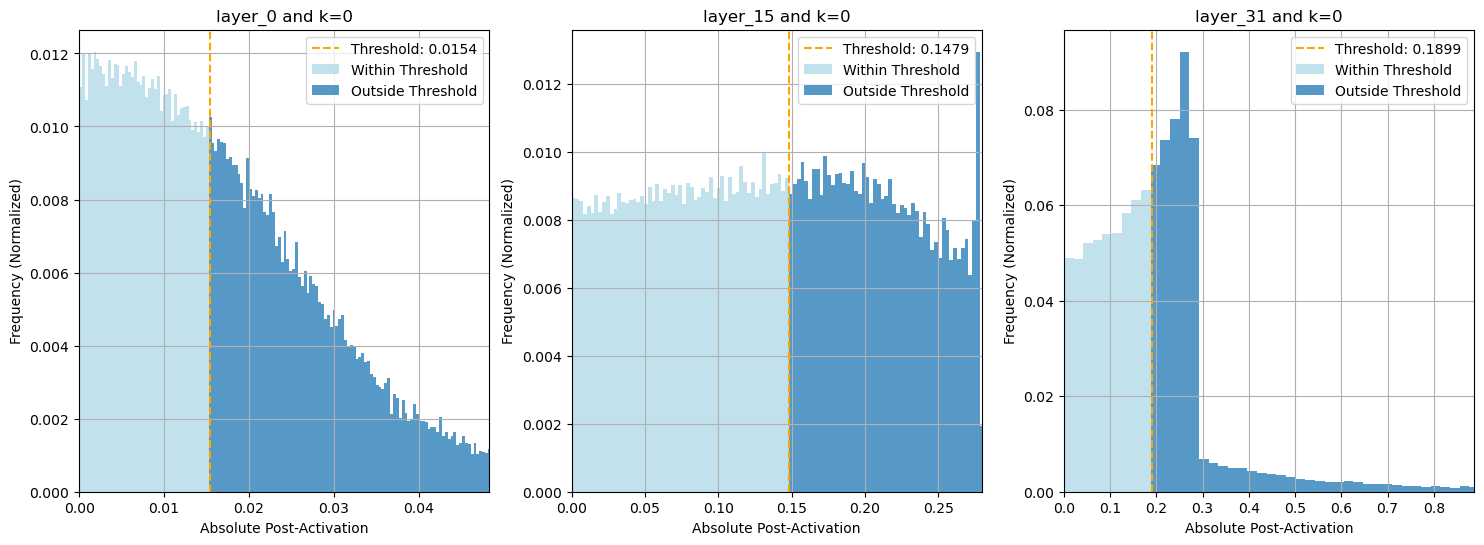

In [16]:
plot_histograms_and_cdf_filled(v_list_layers_samples, layer_threshold_05, y_threshold=0.001,save_plots='xsum-20-50-hist-1000bins', bins_num=1000)

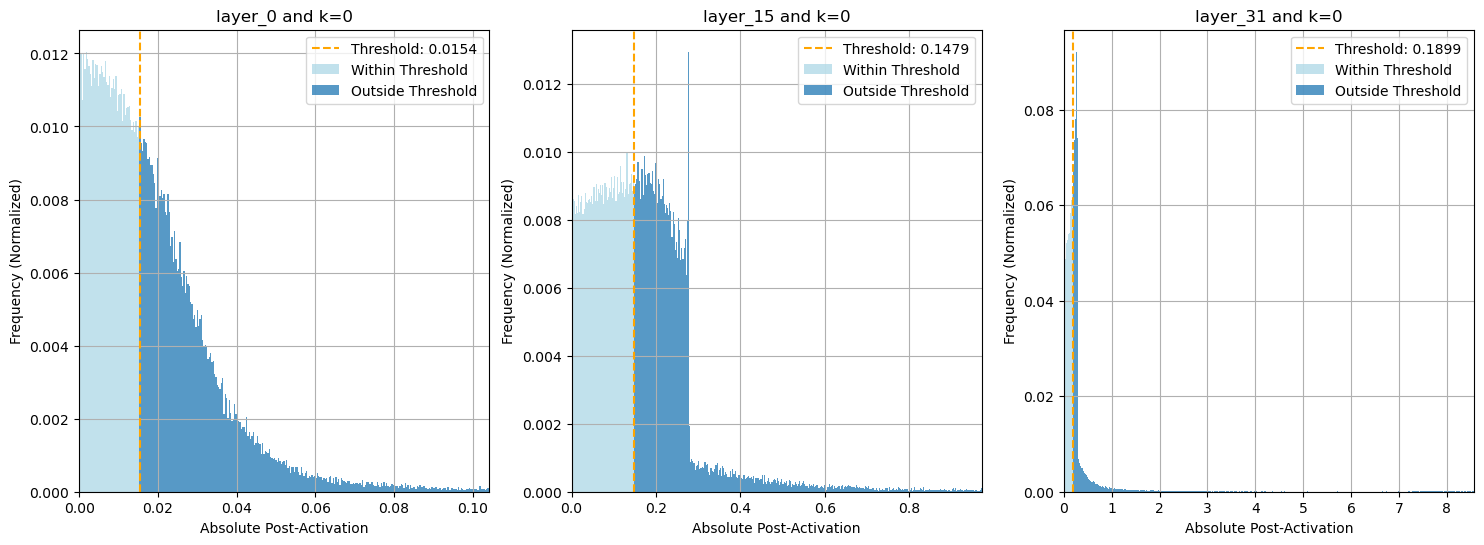

In [17]:
plot_histograms_and_cdf_filled(v_list_layers_samples, layer_threshold_05, y_threshold=0.0001,save_plots='xsum-20-50-hist-1000bins', bins_num=1000)

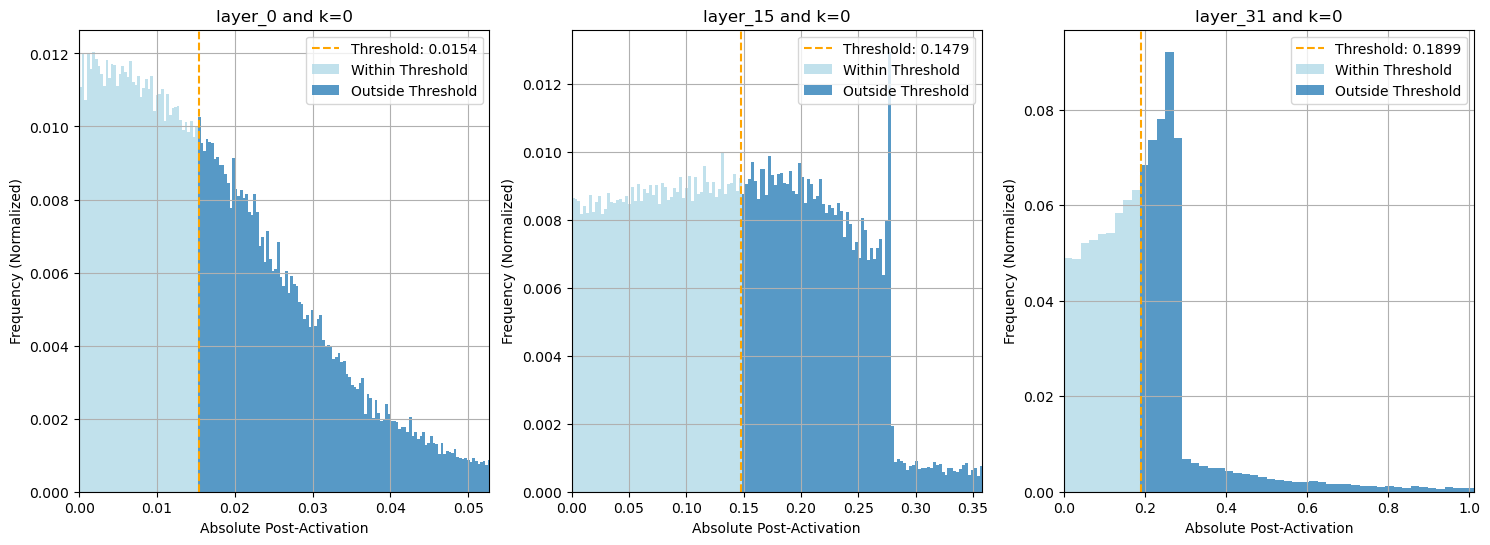

In [18]:
plot_histograms_and_cdf_filled(v_list_layers_samples, layer_threshold_05, y_threshold=0.0007,save_plots='xsum-20-50-hist-1000bins', bins_num=1000)